## Amazon Dataset Test

In [8]:
import pandas as pd
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score

In [9]:
df = pd.read_csv("cleaned_reviews_amazon.csv")
print(df.columns)

Index(['label', 'cleaned_review'], dtype='object')


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

def bag_of_words(textos):
    vectorizer = CountVectorizer()
    actual = []
    for i in range(len(textos)):
        actual.append(textos[i])

    X = vectorizer.fit_transform(actual)
    diccionario = vectorizer.get_feature_names_out()
    bow = X.toarray()
    return diccionario, bow

In [11]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 5),   # Unigram + bigram + trigram
    analyzer='word',
    strip_accents='unicode',
    min_df=2,           # Ignore terms appearing in less than 3 reviews
    max_df=0.9          # Ignore terms appearing in more than 80% of reviews
)

# Apply TF-IDF
X = vectorizer.fit_transform(tqdm(df["cleaned_review"], desc="Vectorizing with TF-IDF"))
print(f"TF-IDF matrix shape: {X.shape}")


Vectorizing with TF-IDF: 100%|██████████| 100000/100000 [00:40<00:00, 2465.74it/s]


TF-IDF matrix shape: (100000, 1419267)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, df["label"], test_size=0.30, random_state=42, stratify=df["label"]
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")


Train size: 70000
Validation size: 15000
Test size: 15000


In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# Definiamo il modello base
sgd = SGDClassifier(random_state=42)

# Definiamo la distribuzione degli iperparametri
param_dist = {
    "loss": ["hinge"],
    "alpha": [1e-5],
    "penalty": ["l2"],
    "max_iter": [2000],
    "learning_rate": ["optimal"],
    "eta0": [0.01],
}

# Scorer: f1 macro per bilanciare classi
scorer = make_scorer(f1_score, average='macro')

# Setup RandomizedSearch
random_search = RandomizedSearchCV(
    sgd,
    param_distributions=param_dist,
    n_iter=50,  # puoi aumentare se hai tempo
    scoring=scorer,
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42,
)

# Fit
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\thesa\anaconda3\envs\py311ml\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=SGDClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'alpha': [1e-05], 'eta0': [0.01],
                                        'learning_rate': ['optimal'],
                                        'loss': ['hinge'], 'max_iter': [2000],
                                        'penalty': ['l2']},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro),
                   verbose=2)

In [14]:
print("Best parameters found:")
print(random_search.best_params_)

best_model = random_search.best_estimator_

# Valutazione su validation set
y_val_pred = best_model.predict(X_val)
print("\nValidation set evaluation:")
print(classification_report(y_val, y_val_pred))


Best parameters found:
{'penalty': 'l2', 'max_iter': 2000, 'loss': 'hinge', 'learning_rate': 'optimal', 'eta0': 0.01, 'alpha': 1e-05}

Validation set evaluation:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      7500
           1       0.89      0.90      0.89      7500

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



In [15]:
y_test_pred = best_model.predict(X_test)
print("\nFinal evaluation on test set:")
print(classification_report(y_test, y_test_pred))



Final evaluation on test set:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7500
           1       0.89      0.90      0.90      7500

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



In [16]:
# --- 7. Load the dataset for prediction ---
prediction_data_file = "reviews_labelled_gemini.csv"
print(f"\nLoading data for prediction from: {prediction_data_file}")
try:
    df_predict = pd.read_csv(prediction_data_file)
    print(f"Successfully loaded {len(df_predict)} rows for prediction.")
except FileNotFoundError:
    print(f"Error: File not found at {prediction_data_file}")
    # Handle error
    raise
except Exception as e:
    print(f"An error occurred while loading {prediction_data_file}: {e}")
    raise

# --- 8. Prepare prediction data ---
# Ensure the column containing reviews exists and rename if necessary
if 'comments' in df_predict.columns:
    df_predict = df_predict.rename(columns={'comments': 'review'})
    print("Renamed prediction column 'comments'->'review'.")
elif 'review' not in df_predict.columns:
     raise ValueError("Prediction DataFrame must contain a 'review' column (or 'comments').")

# Handle potential NaN/empty reviews in the prediction set before tokenization
df_predict.dropna(subset=['review'], inplace=True)
df_predict = df_predict[df_predict['review'].str.strip().astype(bool)]
print(f"Prepared {len(df_predict)} non-empty reviews for prediction.")

print("\nPrediction DataFrame head:")
print(df_predict.head())


Loading data for prediction from: reviews_labelled_gemini.csv
Successfully loaded 1000 rows for prediction.
Renamed prediction column 'comments'->'review'.
Prepared 1000 non-empty reviews for prediction.

Prediction DataFrame head:
            listing_id                   id        date  reviewer_id  \
0              7452173             83955523  2016-07-04     15340719   
1   820745358588537821   915062176998968649  2023-06-16    122233215   
2   826201900527590906  1122374106482196092  2024-03-28    160169071   
3  1089847010707927485  1180360314242415307  2024-06-16     21888322   
4             36723848            594731286  2020-01-19    112579274   

  reviewer_name                                             review  \
0         Brian  Excellent penthouse apartment in a great locat...   
1     Guillaume  Would recommend! Very friendly host and and re...   
2         Laura  Great one bedroom apartment. Very clean and ta...   
3      Viktoria  Well equipped, sunny and nicely desig

In [18]:
# 1. Trasforma le review con il vettorizzatore
X_pred = vectorizer.transform(df_predict['review'])

# 2. Predici le etichette
y_true = df_predict['sentiment_label']
y_pred = best_model.predict(X_pred)

# 3. Stampa le metriche
print("\nValutazione su dataset di predizione:")
print(classification_report(y_true, y_pred, digits=4))
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")


Valutazione su dataset di predizione:
              precision    recall  f1-score   support

           0     0.1148    0.3889    0.1772        36
           1     0.9749    0.8880    0.9294       964

    accuracy                         0.8700      1000
   macro avg     0.5448    0.6384    0.5533      1000
weighted avg     0.9440    0.8700    0.9023      1000

Accuracy: 0.8700


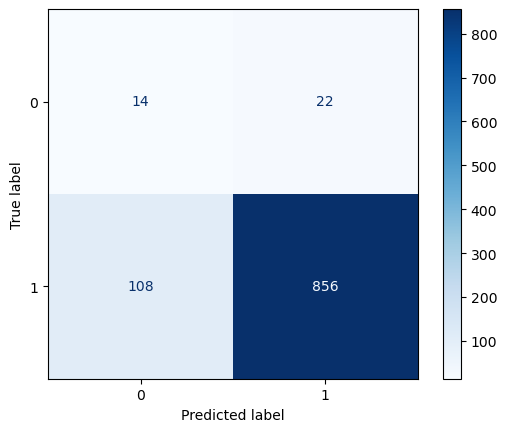

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")